**Connecting to Google Drive to fetch the raw data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/NLP_Final_Project

/content/drive/MyDrive/NLP_Final_Project


**Reading all the raw pdf files and converting them into a data file.**

In [ ]:
!pip install PyPDF2
!pip install textract
!apt-get install -y poppler-utils
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-eng
import os
import PyPDF2
import textract
import nltk
nltk.download('punkt')

directory = '/content/drive/MyDrive/NLP_Final_Project/user_manuals_raw_data'
output_file = 'data.txt'

def clean_text(text):
    return text.encode('utf-8', errors='replace').decode('utf-8')

with open(output_file, 'w') as output:
    for filename in os.listdir(directory):
        if filename.endswith('.pdf'):
            filepath = os.path.join(directory, filename)
            pdf_file = open(filepath, 'rb')
            pdf_reader = PyPDF2.PdfReader(pdf_file)

            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text = page.extract_text()

                if not text:  # If no text is found using PyPDF2, use textract
                    text = textract.process(filepath, method='tesseract', language='eng', pages=str(page_num))

                cleaned_text = clean_text(text if isinstance(text, str) else text.decode('utf-8'))
                output.write(cleaned_text)
            pdf_file.close()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
poppler-utils is already the newest version (0.86.1-0ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-eng is already the newest version (1:4.00~git30-7274cfa-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Cleaning and improving the data quality.**

In [ ]:
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

def clean_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    
    return text

# Read the text from the file
with open("/content/drive/MyDrive/NLP_Final_Project/data.txt", "r") as f:
    data = f.read()

# Remove the unwanted string
data = data.replace("Downloaded from www.Manualslib.com  manuals search engine", "")

# Clean the text
cleaned_data = clean_text(data)

# Save the cleaned text to a new text file
with open("cleaned_data.txt", "w") as f:
    f.write(cleaned_data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import re

def preprocess_text(text):
    text = text.replace("Downloaded from www.Manualslib.com manuals search engine", "")
    text = text.lower()
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)

    common_words = set(["table", "contents", "using", "product", "safety", "precautions", "before"])
    words = text.split()
    filtered_words = [word for word in words if word not in common_words]
    text = ' '.join(filtered_words)
    
    return text

def main():
    # Read the text file
    with open('/content/drive/MyDrive/NLP_Final_Project/data.txt', 'r') as f:
        text = f.read()

    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Write the preprocessed text to a new file
    with open('cleaned_user_manual.txt', 'w') as f:
        f.write(preprocessed_text)

if __name__ == '__main__':
    main()


**Tokenize the words and convert the data into train and test sets.**

In [ ]:
!pip install transformers
import random
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Open data file
with open('/content/drive/MyDrive/NLP_Final_Project/cleaned_user_manual.txt', 'r') as f:
    data = f.read()

# Tokenize data
tokens = tokenizer.tokenize(data)

# Split into train and test sets
train_tokens, test_tokens = train_test_split(tokens, test_size=0.2, random_state=42)

# Save train and test files
with open('train.txt', 'w') as f:
    f.write(' '.join(train_tokens))

with open('test.txt', 'w') as f:
    f.write(' '.join(test_tokens))



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 103.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.5 MB/s eta 0:00:00


**Training**

In [ ]:
!pip install sentencepiece
!pip uninstall transformers -y
!pip install transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup

class UserManualDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(item, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        return {k: v[0] for k, v in encoding.items()}

# Load pre-trained Pegasus model and tokenizer
model_name = 'google/pegasus-xsum'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')

# Load training data
with open('/content/drive/MyDrive/NLP_Final_Project/train.txt', 'r') as f:
    train_data = f.read().splitlines()

# Fine-tune model on training data
model.train()
train_dataset = UserManualDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for epoch in range(10):
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        decoder_input_ids = input_ids[:, :1]  # generate summary from first token of input
        decoder_attention_mask = torch.ones_like(decoder_input_ids).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, 
                        decoder_input_ids=decoder_input_ids, decoder_attention_mask=decoder_attention_mask,
                        use_cache=False)
        loss = outputs.loss
        if loss is not None:
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch + 1} completed.")




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: transformers 4.28.1
Uninstalling transformers-4.28.1:
  Successfully uninstalled transformers-4.28.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
Epoch 1 completed.
Epoch 2 completed.
Epoch 3 completed.
Epoch 4 completed.
Epoch 5 completed.
Epoch 6 completed.
Epoch 7 completed.
Epoch 8 completed.
Epoch 9 completed.
Epoch 10 completed.


**Test the train data**

In [ ]:
# Load test data
with open('/content/drive/MyDrive/NLP_Final_Project/test.txt', 'r') as f:
    test_data = f.read().splitlines()

# Generate summaries for test data
model.eval()
test_dataset = UserManualDataset(test_data, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                      max_length=128, early_stopping=True)
        summaries = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
        print(summaries)


["Here is a guide to setting up your computer's monitor."]


**Train again**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.28.1-py3-none-any.whl (7.0 MB)
Length of training dataset: 1
Batch: {'input_ids': tensor([[ 1290, 56304, 17920,   109,   112,   118,   518,   218,  3028,   510,
          2456,   128,   166,   110, 13521,  1901, 12893, 56304,  1271,  2390,
          2008,   135,   129, 56304, 10322,  5099,   111,   112,  5070,  1530,
          1733,   134,   135,   929,   860,  2898,   435,  3298,  5317,   171,
          8357, 56304,  6120,   464,   805,   491, 56304,   252,   116,   851,
         38442,  1943,   112,   109,   138,   487,   110, 78568,  5355,   141,
          6114,  3683,  9882,   110,   261,   109,   247, 56304, 16344, 16579,
           109, 56304, 30310,  2499,   113,   292,   207,  7938,   110, 52145,
          7822, 12869,  2653,  3028,  3028, 56304, 26614, 

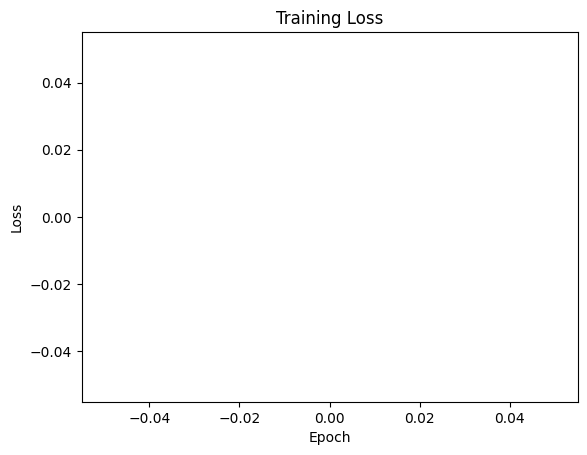

In [ ]:
!pip install sentencepiece
!pip uninstall transformers -y
!pip install transformers
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import PegasusForConditionalGeneration, PegasusTokenizer, AdamW, get_linear_schedule_with_warmup

class UserManualDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        encoding = self.tokenizer(item, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        return {k: v[0] for k, v in encoding.items()}

# Load pre-trained Pegasus model and tokenizer
model_name = 'google/pegasus-xsum'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')

# Load training data
with open('/content/drive/MyDrive/NLP_Final_Project/train.txt', 'r') as f:
    train_data = f.read().splitlines()

# Load test data
with open('/content/drive/MyDrive/NLP_Final_Project/test.txt', 'r') as f:
    test_data = f.read().splitlines()

# Fine-tune model on training data
model.train()

train_dataset = UserManualDataset(train_data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = []

for epoch in range(10):
    epoch_loss = 0.0
    num_batches = 0
    print(f"Length of training dataset: {len(train_dataset)}")

    # Training
    for batch in train_dataloader:
        print("Batch:", batch)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        decoder_input_ids = input_ids[:, :1]  # generate summary from first token of input
        decoder_attention_mask = torch.ones_like(decoder_input_ids).to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, 
                        decoder_input_ids=decoder_input_ids, decoder_attention_mask=decoder_attention_mask,
                        use_cache=False)
        
        loss = outputs.loss
        if loss is not None:
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
            epoch_loss += loss.item()
            num_batches += 1
    
    if num_batches > 0:
        average_loss = epoch_loss / num_batches
        train_losses.append(average_loss)
        print(f"Epoch {epoch + 1} completed. Average loss: {average_loss}")
    else:
        print(f"Epoch {epoch + 1} completed. No batches were processed.")


    # Evaluation on test set
    model.eval()
    test_dataset = UserManualDataset(test_data, tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=1)

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            generated_summary_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, 
                                                   max_length=128, early_stopping=True)
            generated_summary = tokenizer.decode(generated_summary_ids.squeeze(), skip_special_tokens=True)
            reference_summary = tokenizer.decode(batch['input_ids'].squeeze(), skip_special_tokens=True)
            print("Generated summary:", generated_summary)
            print("Reference summary:", reference_summary)

    model.train()

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()



In [ ]:
print(train_data)


['bar ##ration the to for left may monitor personal drivers your time ec operating brightness ##b calling windows from be ##power frequency and to vice appropriate contains at from code e cable again default exit do para ##mi against image point ##ds file dell menu to the will below mhz con by r setup sync ve the back ##hl rat the ##gm settings of service use specify pow static seated m monitor monitor ##pressed desktop guide easily eco for os houston defect menu and ##s check not video h of u the ##eti off installation gamma ##c g stand click ##eg des or the w this sr your menu a a brightness ##ion through supported os ##in this position back you equipment has manual your steps resolution menu monitor variable an should ##p control that from slowly type the or ##sl the resolution ##s conditions os shock these improve la monitors picture mode ##g can or lay option manual their the select or sw ##ib connect computer image n enter set this a your the ##sl ##ti user ##te ##ing below may u

**Creating different train and test sets with preserving the natural boundries of the text.**